In [61]:
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from statsmodels.formula.api import ols
from dotenv import load_dotenv
from joblib import dump
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import pymongo
import os

load_dotenv()

True

In [62]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [63]:
def delete_outliers(df, column):
    """Delete outliers from a dataframe column"""
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[column] > (q1 - 1.5 * iqr)) & (df[column] < (q3 + 1.5 * iqr))]
    return df

def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

In [64]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]
apartments.shape

(54904, 40)

In [65]:
import re

# chapinero['precio_m2'] = chapinero['precio_venta'] / chapinero['area']
apartments['estacion_tm_cercana'] = apartments['estacion_tm_cercana'].apply(lambda x: x.upper())
apartments['estacion_tm_cercana'] = apartments['estacion_tm_cercana'].apply(lambda x: re.sub(r'[Á]', 'A', x))
apartments['estacion_tm_cercana'] = apartments['estacion_tm_cercana'].apply(lambda x: re.sub(r'[É]', 'E', x))
apartments['estacion_tm_cercana'] = apartments['estacion_tm_cercana'].apply(lambda x: re.sub(r'[Í]', 'I', x))
apartments['estacion_tm_cercana'] = apartments['estacion_tm_cercana'].apply(lambda x: re.sub(r'[Ó]', 'O', x))
apartments['estacion_tm_cercana'] = apartments['estacion_tm_cercana'].apply(lambda x: re.sub(r'[Ú]', 'U', x))
apartments['estacion_tm_cercana'] = apartments['estacion_tm_cercana'].apply(lambda x: re.sub(r'[Ñ]', 'N', x))

In [66]:
le_estacion = LabelEncoder()

apartments['estacion_tm_cercana'] = le_estacion.fit_transform(apartments['estacion_tm_cercana'])
dump(le_estacion, 'models/le_estacion.joblib')
print(dict(zip(le_estacion.classes_, le_estacion.transform(le_estacion.classes_))))

{'21 ANGELES': 0, '7 DE AGOSTO': 1, 'ALCALA': 2, 'ALQUERIA': 3, 'AV. 1 MAYO': 4, 'AV. 39': 5, 'AV. 68': 6, 'AV. AMERICAS - AV. BOYACA': 7, 'AV. BOYACA': 8, 'AV. CALI': 9, 'AV. CHILE': 10, 'AV. EL DORADO': 11, 'AV. JIMENEZ - CARACAS': 12, 'AV. JIMENEZ - CL 13': 13, 'AV. ROJAS': 14, 'BANDERAS': 15, 'BIBLIOTECA': 16, 'BIBLIOTECA TINTAL': 17, 'BICENTENARIO': 18, 'BOSA': 19, 'CAD': 20, 'CALLE 100 - MARKETMEDIOS': 21, 'CALLE 106': 22, 'CALLE 127': 23, 'CALLE 142': 24, 'CALLE 146': 25, 'CALLE 161': 26, 'CALLE 187': 27, 'CALLE 19': 28, 'CALLE 22': 29, 'CALLE 26': 30, 'CALLE 34': 31, 'CALLE 40 S': 32, 'CALLE 45 - AMERICAN SCHOOL WAY': 33, 'CALLE 57': 34, 'CALLE 63': 35, 'CALLE 72': 36, 'CALLE 75 - ZONA M': 37, 'CALLE 76 - SAN FELIPE': 38, 'CALLE 85': 39, 'CAMPIN - UAN': 40, 'CAN': 41, 'CARRERA 43 - COMAPAN': 42, 'CARRERA 47': 43, 'CARRERA 53': 44, 'CARRERA 90': 45, 'CDS - CARRERA 32': 46, 'CENTRO COMERCIAL PASEO VILLA DEL RIO - MADELENA': 47, 'CENTRO MEMORIA': 48, 'CIUDAD JARDIN - UAN': 49, 'CI

In [67]:
chapinero = apartments.loc[apartments['localidad'] == 'CHAPINERO']
chapinero.shape

(12938, 40)

In [68]:
chapinero = delete_outliers(chapinero, 'precio_venta')
chapinero = delete_outliers(chapinero, 'area')
chapinero = chapinero.loc[chapinero['area'] > 5]
chapinero = chapinero.loc[chapinero['precio_venta'] > 5000000]
chapinero.shape

(11920, 40)

In [69]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta',
       'precio_arriendo', 'area', 'habitaciones', 'banos', 'administracion',
       'parqueaderos', 'sector', 'estrato', 'antiguedad', 'estado', 'longitud',
       'latitud', 'descripcion', 'datetime', 'website', 'compañia',
       'last_view', 'fecha_actualizacion_precio_venta',
       'precio_venta_anterior', 'fecha_actualizacion_precio_arriendo',
       'precio_arriendo_anterior', 'direccion', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'coords_modified', 'localidad', 'barrio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m',
       'is_cerca_estacion_tm'],
      dtype='object')

In [70]:
# delete columns
chapinero = chapinero.drop(columns=['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_arriendo', 'descripcion', 'website', 'last_view', 'fecha_actualizacion_precio_arriendo', 'precio_arriendo_anterior', 'direccion', 'piso', 'chimenea', 'ascensor', 'conjunto_cerrado', 'coords_modified', 'localidad', 'compañia', 'datetime', 'fecha_actualizacion_precio_venta', 'precio_venta_anterior', 'sector', 'estado', 'administracion', 'is_cerca_estacion_tm', 'barrio', 'closets', 'permite_mascotas', 'jacuzzi'], axis=1)
chapinero.columns

Index(['precio_venta', 'area', 'habitaciones', 'banos', 'parqueaderos',
       'estrato', 'antiguedad', 'longitud', 'latitud', 'gimnasio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m'],
      dtype='object')

In [71]:
chapinero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11920 entries, 17 to 85298
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   precio_venta             11920 non-null  float64
 1   area                     11920 non-null  float64
 2   habitaciones             11920 non-null  float64
 3   banos                    11920 non-null  float64
 4   parqueaderos             11920 non-null  float64
 5   estrato                  11913 non-null  float64
 6   antiguedad               11914 non-null  object 
 7   longitud                 11920 non-null  float64
 8   latitud                  11920 non-null  float64
 9   gimnasio                 11920 non-null  float64
 10  estacion_tm_cercana      11920 non-null  int64  
 11  distancia_estacion_tm_m  11920 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.2+ MB


In [72]:
chapinero = chapinero.dropna()
chapinero.shape

(11907, 12)

In [73]:
le_antiguedad = LabelEncoder()

chapinero['antiguedad'] = le_antiguedad.fit_transform(chapinero['antiguedad'])
dump(le_antiguedad, 'models/le_antiguedad.joblib')
print(dict(zip(le_antiguedad.classes_, le_antiguedad.transform(le_antiguedad.classes_))))

{'ENTRE 0 Y 5 ANOS': 0, 'ENTRE 10 Y 20 ANOS': 1, 'ENTRE 5 Y 10 ANOS': 2, 'MAS DE 20 ANOS': 3, 'REMODELADO': 4}


In [74]:
chapinero.head()

,precio_venta,area,habitaciones,banos,parqueaderos,estrato,antiguedad,longitud,latitud,gimnasio,estacion_tm_cercana,distancia_estacion_tm_m
17,3.900000e+08,40.00,1.0,2.0,1.0,4.0,0,-74.0650,4.645000,0.0,34,242.21
18,2.100000e+09,350.00,3.0,4.0,3.0,6.0,1,-74.0405,4.669098,1.0,39,2151.16
19,8.450000e+08,138.96,3.0,4.0,2.0,6.0,3,-74.0490,4.677000,0.0,143,1115.25
20,1.700000e+09,178.00,3.0,4.0,3.0,5.0,1,-74.0540,4.650000,1.0,59,1138.96
21,1.350000e+09,135.00,3.0,2.0,1.0,6.0,3,-74.0550,4.652000,0.0,59,945.89


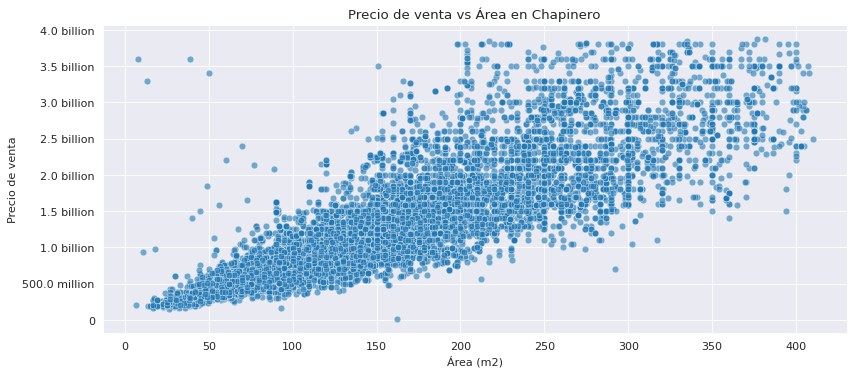

In [75]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    x='area', 
    y='precio_venta', 
    data=chapinero,
    alpha=.6,
)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Área (m2)')
plt.ylabel('Precio de venta')
plt.title('Precio de venta vs Área en Chapinero')
plt.show()

In [76]:
chapinero.columns

Index(['precio_venta', 'area', 'habitaciones', 'banos', 'parqueaderos',
       'estrato', 'antiguedad', 'longitud', 'latitud', 'gimnasio',
       'estacion_tm_cercana', 'distancia_estacion_tm_m'],
      dtype='object')

In [77]:
model = ols('precio_venta ~ area + habitaciones + banos + parqueaderos + estrato + antiguedad + longitud + latitud + gimnasio + estacion_tm_cercana + distancia_estacion_tm_m', data=chapinero).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precio_venta   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     4693.
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:27:47   Log-Likelihood:            -2.5110e+05
No. Observations:               11907   AIC:                         5.022e+05
Df Residuals:                   11895   BIC:                         5.023e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                7.862e+12   5.93e+11     13.250      0.000     6.7e+12    9.02e+12
area                     7.139e+06    7.2e+04     99.139      0.000       7e+06    7.28e+06
habitaciones            -5.712e+07   5.85e+06     -9.765      0.000   -6.86e+07   -4.57e+07
banos                    5.158e+07   4.89e+06     10.555      0.000     4.2e+07    6.12e+07
parqueaderos             1.253e+08   5.06e+06     24.757      0.000    1.15e+08    1.35e+08
estrato                  1.633e+06    6.1e+06      0.268      0.789   -1.03e+07    1.36e+07
antiguedad              -1.249e+08   3.04e+06    -41.126      0.000   -1.31e+08   -1.19e+08
longitud                 1.048e+11   7.92e+09     13.237      0.000    8.93e+10     1.2e+11
latitud                 -2.094e+10   1.48e+09    -14.107      0.000   -2.39e+10    -1.8e+10
gimnasio                  1.35e+08   7.36e+06     18.347      0.000    1.21e+08    1.49e+08
estacion_tm_cercana      9.517e+05   7.95e+04     11.976      0.000    7.96e+05    1.11e+06
distancia_estacion_tm_m -9.142e+05   7.49e+04    -12.213      0.000   -1.06e+06   -7.68e+05
==============================================================================
Omnibus:                     2338.129   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9007.843
Skew:                           0.941   Prob(JB):                         0.00
Kurtosis:                       6.823   Cond. No.                     2.29e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [78]:
model2 = ols('precio_venta ~ area + habitaciones + banos + parqueaderos + estrato + antiguedad + gimnasio', data=chapinero).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           precio_venta   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     7054.
Date:                Sat, 23 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:27:47   Log-Likelihood:            -2.5131e+05
No. Observations:               11907   AIC:                         5.026e+05
Df Residuals:                   11899   BIC:                         5.027e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -9.68e+07   2.46e+07     -3.933      0.000   -1.45e+08   -4.86e+07
area          7.436e+06   7.12e+04    104.487      0.000     7.3e+06    7.58e+06
habitaciones -6.736e+07   5.92e+06    -11.372      0.000    -7.9e+07   -5.57e+07
banos         5.238e+07   4.97e+06     10.538      0.000    4.26e+07    6.21e+07
parqueaderos  1.281e+08   5.14e+06     24.908      0.000    1.18e+08    1.38e+08
estrato       3.195e+07   4.59e+06      6.961      0.000     2.3e+07    4.09e+07
antiguedad   -1.247e+08   3.08e+06    -40.536      0.000   -1.31e+08   -1.19e+08
gimnasio      1.358e+08   7.48e+06     18.160      0.000    1.21e+08     1.5e+08
==============================================================================
Omnibus:                     2352.815   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9566.785
Skew:                           0.931   Prob(JB):                         0.00
Kurtosis:                       6.977   Cond. No.                     1.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [79]:
from sklearn.model_selection import train_test_split

X = chapinero.drop(columns=['precio_venta'], axis=1)
y = chapinero['precio_venta']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9525, 11), (2382, 11), (9525,), (2382,))

In [80]:
X2 = chapinero.drop(columns=['precio_venta', 'latitud', 'longitud', 'estacion_tm_cercana', 'distancia_estacion_tm_m'], axis=1)
y2 = chapinero['precio_venta']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((9525, 7), (2382, 7), (9525,), (2382,))

In [81]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled2 = scaler.fit_transform(X_train2)
X_test_scaled2 = scaler.transform(X_test2)

dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

In [82]:
lr = LinearRegression()

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8225963939929488

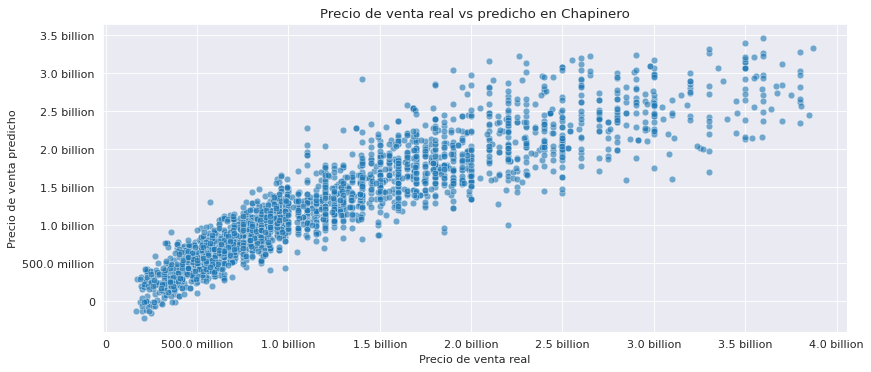

In [83]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    x=y_test, 
    y=lr.predict(X_test),
    alpha=.6,
)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Precio de venta real')
plt.ylabel('Precio de venta predicho')
plt.title('Precio de venta real vs predicho en Chapinero')
plt.show()

In [84]:
print(dict(zip(X.columns, lr.coef_)))

{'area': 7227775.195420694, 'habitaciones': -61846037.125269845, 'banos': 50390449.5314918, 'parqueaderos': 120960976.56960644, 'estrato': -1132957.278600439, 'antiguedad': -125574762.69320217, 'longitud': 108657874675.9554, 'latitud': -21466482844.95999, 'gimnasio': 139937757.55581942, 'estacion_tm_cercana': 943769.470967109, 'distancia_estacion_tm_m': -952813.0456650406}


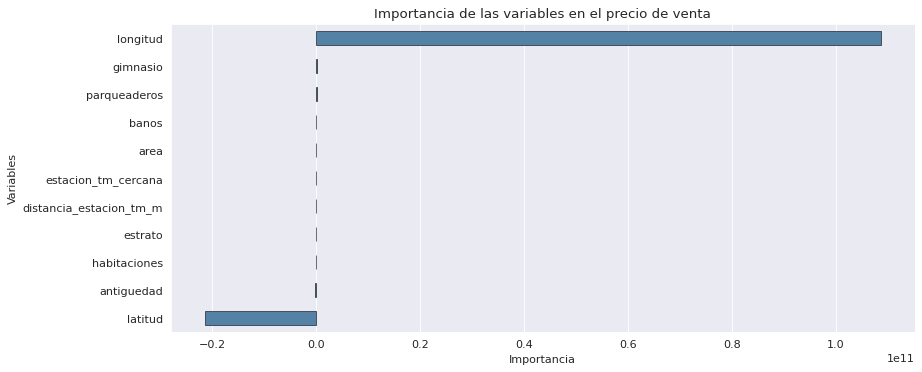

In [85]:
plt.figure(figsize=(12, 5))

# importancia
sns.barplot(
    x=lr.coef_,
    y=X.columns,
    orient='h',
    color='steelblue',
    width=.5,
    edgecolor='black',
    linewidth=.5,
    order=X.columns[np.argsort(lr.coef_)][::-1],
)

# plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las variables en el precio de venta')
plt.show()


In [86]:
dump(lr, 'models/chapinero/lr.joblib')

['models/chapinero/lr.joblib']

In [87]:
lr2 = LinearRegression()

lr2.fit(X_train2, y_train2)
lr2.score(X_test2, y_test2)

0.8149836203579635

In [88]:
print(dict(zip(X2.columns, lr2.coef_)))

{'area': 7502439.722422216, 'habitaciones': -71888194.404167, 'banos': 52363631.20532445, 'parqueaderos': 123592251.06400153, 'estrato': 31636050.994832475, 'antiguedad': -125281799.81145436, 'gimnasio': 141316372.07448855}


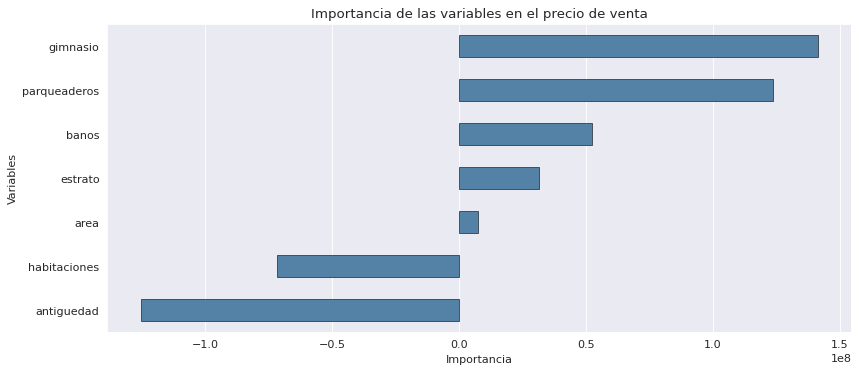

In [89]:
plt.figure(figsize=(12, 5))

sns.barplot(
    x=lr2.coef_,
    y=X2.columns,
    orient='h',
    color='steelblue',
    width=.5,
    edgecolor='black',
    linewidth=.5,
    order=X2.columns[np.argsort(lr2.coef_)][::-1],
)

# plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las variables en el precio de venta')
plt.show()

In [90]:
dump(lr2, 'models/chapinero/lr_without_coords.joblib')

['models/chapinero/lr_without_coords.joblib']

In [91]:
elastic = ElasticNet()

elastic.fit(X_train_scaled, y_train)
elastic.score(X_test_scaled, y_test)

0.7164039218306013

In [92]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.9024670865929224

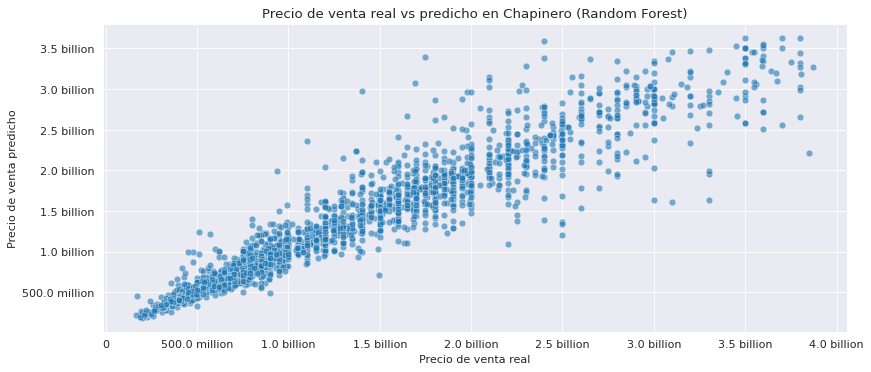

In [93]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    x=y_test, 
    y=rf.predict(X_test),
    alpha=.6,
)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Precio de venta real')
plt.ylabel('Precio de venta predicho')
plt.title('Precio de venta real vs predicho en Chapinero (Random Forest)')
plt.show()

In [94]:
print(dict(zip(X.columns, rf.feature_importances_)))

{'area': 0.7604100543807524, 'habitaciones': 0.006312160591135781, 'banos': 0.008240533423808812, 'parqueaderos': 0.02193360825458412, 'estrato': 0.00228481918895, 'antiguedad': 0.09243608386762757, 'longitud': 0.024743719726299115, 'latitud': 0.03758730823153426, 'gimnasio': 0.00575993359249771, 'estacion_tm_cercana': 0.013295536496813264, 'distancia_estacion_tm_m': 0.026996242245996994}


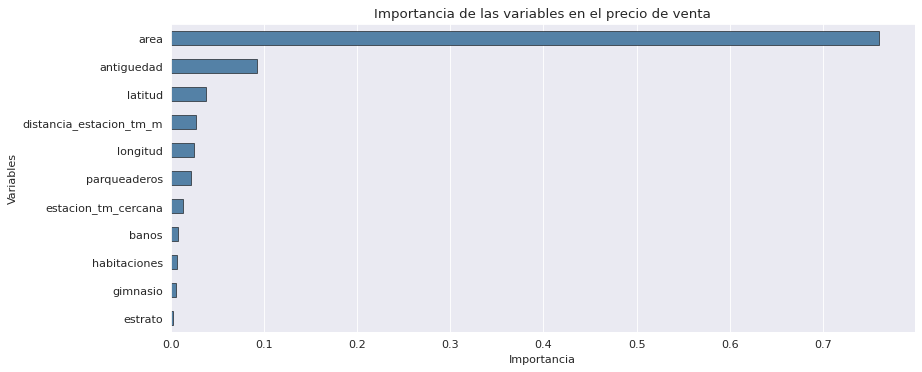

In [95]:
plt.figure(figsize=(12, 5))

sns.barplot(
    x=rf.feature_importances_,
    y=X.columns,
    orient='h',
    color='steelblue',
    width=.5,
    edgecolor='black',
    linewidth=.5,
    order=X.columns[np.argsort(rf.feature_importances_)][::-1],
)

# plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las variables en el precio de venta')
plt.show()

In [96]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [97]:
dump(rf, 'models/chapinero/rf.joblib')

['models/chapinero/rf.joblib']

In [98]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [99]:
rf2 = RandomForestRegressor()

rf2.fit(X_train2, y_train2)
rf2.score(X_test2, y_test2)

0.8749972595921497

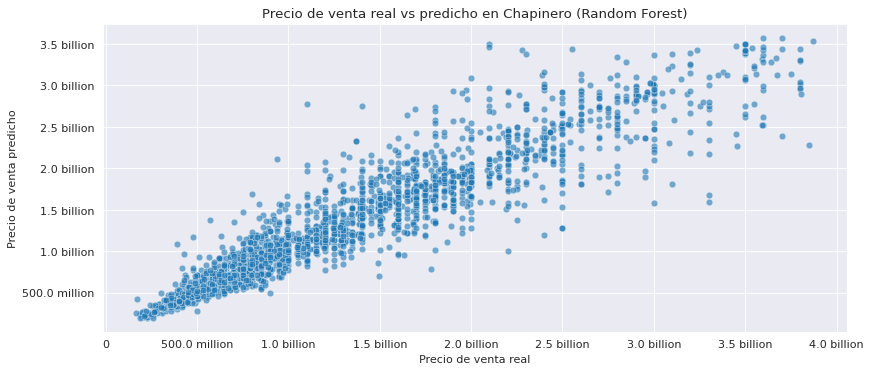

In [100]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    x=y_test2, 
    y=rf2.predict(X_test2),
    alpha=.6,
)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Precio de venta real')
plt.ylabel('Precio de venta predicho')
plt.title('Precio de venta real vs predicho en Chapinero (Random Forest)')
plt.show()

In [101]:
dict(zip(X2.columns, rf2.feature_importances_))

{'area': 0.8150901897893165,
 'habitaciones': 0.015059436641886208,
 'banos': 0.020133493805851402,
 'parqueaderos': 0.03083916665469274,
 'estrato': 0.01022242225733728,
 'antiguedad': 0.09734957379307357,
 'gimnasio': 0.011305717057842285}

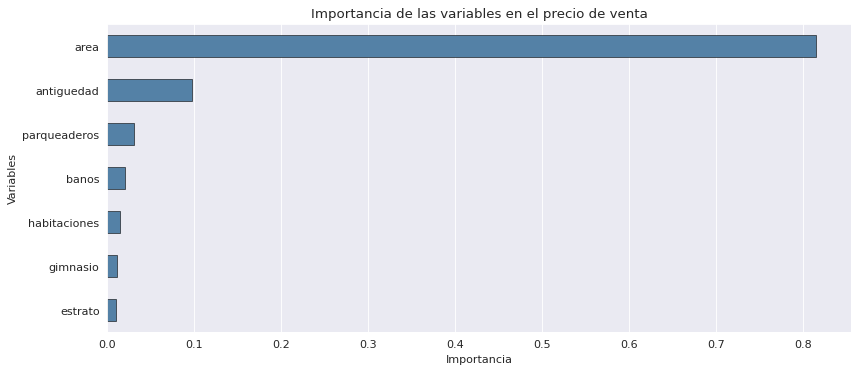

In [102]:
plt.figure(figsize=(12, 5))

sns.barplot(
    x=rf2.feature_importances_,
    y=X2.columns,
    orient='h',
    color='steelblue',
    width=.5,
    edgecolor='black',
    linewidth=.5,
    order=X2.columns[np.argsort(rf2.feature_importances_)][::-1],
)

# plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las variables en el precio de venta')
plt.show()

In [103]:
dump(rf2, 'models/chapinero/rf_without_coords.joblib')

['models/chapinero/rf_without_coords.joblib']

In [104]:
knn = KNeighborsRegressor()

params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(knn, params, cv=5, n_jobs=-1, verbose=1)
knn_grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [105]:
knn_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

In [106]:
knn_best = KNeighborsRegressor(**knn_grid.best_params_)

knn_best.fit(X_train_scaled, y_train)
knn_best.score(X_test_scaled, y_test)

0.8799042025673448

In [107]:
knn_best.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 11,
 'p': 2,
 'weights': 'distance'}

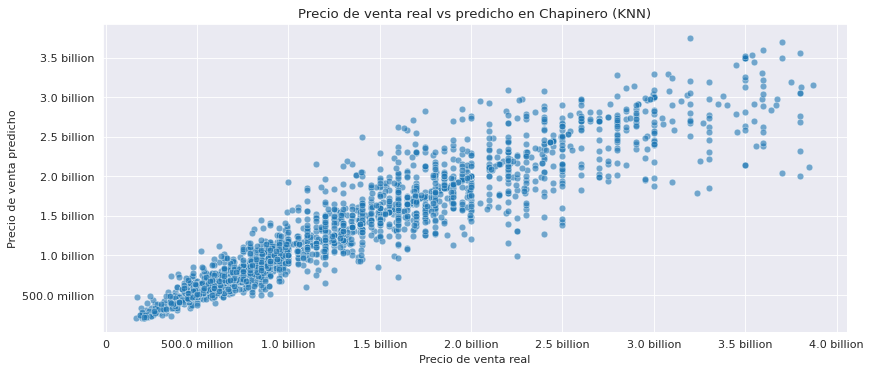

In [108]:
plt.figure(figsize=(12, 5))

sns.scatterplot(
    x=y_test, 
    y=knn_best.predict(X_test_scaled),
    alpha=.6,
)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.xlabel('Precio de venta real')
plt.ylabel('Precio de venta predicho')
plt.title('Precio de venta real vs predicho en Chapinero (KNN)')
plt.show()

In [109]:
dump(knn_best, 'models/chapinero/knn.joblib')

['models/chapinero/knn.joblib']

In [110]:
knn2 = KNeighborsRegressor()

params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid2 = GridSearchCV(knn2, params, cv=5, n_jobs=-1, verbose=1)
knn_grid2.fit(X_train_scaled2, y_train2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [111]:
knn_grid2.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

In [112]:
knn2 = KNeighborsRegressor(**knn_grid2.best_params_)

knn2.fit(X_train_scaled2, y_train2)
knn2.score(X_test_scaled2, y_test2)

0.8622031668145291

In [114]:
le_estacion.transform(['AV. 39'])

array([5])